# Image Classification using Convolutional Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os 
import torch 
import torchvision 
import tarfile

from torchvision.datasets import CIFAR10
from torch.utils import data

import torch.nn as nn
import torch.nn.functional as F

In [2]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
torchvision.datasets.utils.download_url(url=dataset_url, root='~/Developer/GITHUB/DATA')

Using downloaded and verified file: /Users/shriharimuttagi/Developer/GITHUB/DATA/cifar10.tgz


In [3]:
# Extract from archive 
if os.path.isdir('/Users/shriharimuttagi/Developer/GITHUB/DATA/cifar10')==False:
    with tarfile.open('/Users/shriharimuttagi/Developer/GITHUB/DATA/cifar10.tgz') as tar:
        tar.extractall(path = '/Users/shriharimuttagi/Developer/GITHUB/DATA')

In [4]:
paths = '/Users/shriharimuttagi/Developer/GITHUB/DATA/cifar10'
print(os.listdir(paths))

classes = os.listdir(paths+'/train')
print(classes)

print('Images per label =',len(os.listdir(paths+'/train/bird')))

['.DS_Store', 'test', 'labels.txt', 'train']
['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']
Images per label = 5000


In [5]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Batching the Data

#### Image is RGB (3,x,x)

In [6]:
dataset = torchvision.datasets.ImageFolder(paths+'/train', transform=torchvision.transforms.ToTensor())

print('Total images in Training = ',len(dataset))

img, label = dataset[2]
print('Image shape = {} and Label of image = {}'.format(img.shape, label))

# labeled data
print('labels are = ', dataset.classes)

Total images in Training =  50000
Image shape = torch.Size([3, 32, 32]) and Label of image = 0
labels are =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Initilize the Batch Data & create Validation set
Validation set = 5000
training data = 4500

In [7]:
batch_size = 64
val = 5000
train_size = len(dataset)-val

torch.manual_seed(76)

In [8]:
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val])

print('Training set = {} and Validation Set = {}'.format(len(train_set), len(val_set)))

Training set = 45000 and Validation Set = 5000


#### Randomize Training and validation data

In [9]:
train_set = data.dataloader.DataLoader(train_set,batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_set = data.dataloader.DataLoader(val_set, batch_size=batch_size, num_workers=4, pin_memory=True)

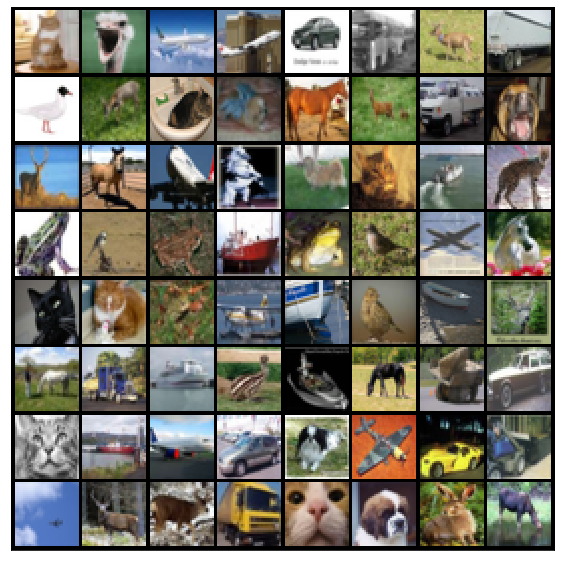

In [10]:
# matplotlib works as (img.hight, img.wight, channels)
# therefore we have to convert (3,x,x) to --> (x,x,3)

def show_batch(batch_imgs):
    for img, label in batch_imgs:
        fig, ax = plt.subplots(figsize = (10,10))
        ax.imshow(torchvision.utils.make_grid(img, nrow=8).permute(1,2,0))
        ax.set_xticks([]), ax.set_yticks([])
        break

show_batch(train_set)

# Define MODEL

INPUT IMAGE ==> CONV LAYER ==> POOLING LAYER ==> CONV LAYER ==> POOLING LAYER ==> FULLY CONNECTED LAYER

In [11]:
# Define HELPER methods containing training and validation

def accuracy(output, label):
    _, pred = torch.max(output, dim=1)
    return torch.tensor(torch.sum(pred == label).item()/len(pred))

class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3, padding=1),
            nn.ReLU(), 
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))  # output: (64,16,16)
            
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.ReLU(), 
            nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))  # output: (128,8,8)
            
#         self.conv_layer3 = nn.Sequential(
#             nn.Conv2d(128,256, kernel_size=3, padding=1),
#             nn.ReLU(), 
#             nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2))  # output: (256,4,4)
            
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            
            nn.Linear(512, 10))

        
    def forward(self, image):
        out1 = self.conv_layer1(img)
        out2 = self.conv_layer2(out1)
        #out3 = self.conv_layer3(out2)
        
        out4 = self.fc_layer(out2)

        return out4
    
    
    def train_step(self, batch):
        img, label = batch
        out = self(img)
        loss = F.cross_entropy(out, label)
        return loss
    
    def val_step(self, batch):
        img, label = batch
        out = self(img)
        #print(out.shape)
        loss = F.cross_entropy(out, label)
        acc = accuracy(out, label)
        return {'val_loss:':loss.detach(), 'val_acc:':acc}
    
    def val_epoch_end(self, output):
        for x in output:
            batch_loss = x['val_loss']
        epoch_loss = torch.stack(batch_loss).mean()
        
        for x in output:
            epoch_acc = x['val_acc']
        epoch_acc = torch.stack(epoch_acc).mean()
        return {'val_loss:':epoch_loss.item(), 'val_acc:':epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch [{}], Training Loss: {:.4f}, Val_Loss: {:.4f}, Val_Acc: {:.4f}'
             .format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))    
        

**nn.Conv2d(number of channels, output channels, kernel, striding, padding)**

Thought it looks like out input shape is 3D, but you have to pass a 4D array at the time of fitting the data which should be like (batch_size, 32, 32, 3)

**Input** = (batch_size, channel_in, ht_in, width_in)\
**output** = (batch_size, channel_out, ht_out, width_out)

In [12]:
# Simple network
simple_model = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2)
max_pool = nn.MaxPool2d(2,2)

for images, labels in train_set:
    print('images shape = ', images.shape)
    out = simple_model(images)
    print('Convolution layer output shape = ', out.shape)
    out1 = max_pool(out)
    print('Max_Pooling shape = ', out1.shape)
    break
    
# ## change kernel_size, stride, padding

images shape =  torch.Size([64, 3, 32, 32])
Convolution layer output shape =  torch.Size([64, 64, 34, 34])
Max_Pooling shape =  torch.Size([64, 64, 17, 17])


In [13]:
model = CNN()
model

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten()
    (1): Linear(in_features=8192, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [14]:
for img,label in train_set:
    print('image.shape', img.shape)
    
    out = model(img).to(device)
    print(out.shape)
    print('out[0]=', out[0])
    break

image.shape torch.Size([64, 3, 32, 32])
torch.Size([64, 10])
out[0]= tensor([ 1.2445e-02, -1.2272e-02, -2.2315e-02, -8.0894e-03, -2.0417e-02,
        -6.0597e-05, -2.4083e-02, -4.8591e-03, -2.3659e-02,  2.9078e-03],
       grad_fn=<SelectBackward>)


# Train the Model

### Fit the Model and Evaluate
model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.


In [15]:
@torch.no_grad()
def evaluation(model, data):
    model.eval()
    outputs = [model.val_step(batch) for batch in data]
    #print(outputs)
    return model.val_epoch_end(outputs)

def fit(epoch, lr, model, train_set, val_set, opt_fun=torch.optim.SGD):
    history=[]
    optimizer = opt_fun(model.parameters(), lr)
    
    for epoch in range(epoch):
        model.train()
        train_loss = []
        for batch in train_set:
            loss = model.train_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation Step
        result = evaluation(model, val_set)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(epoch, result)
        
    return history
            

In [ ]:
for d in train_set:
    output = model.train_step(d)    

In [ ]:
evaluation(model, val_set)

In [ ]:
num_epochs = 2
opt_func = torch.optim.Adam
lr = 0.5

In [ ]:
history = fit(num_epochs, lr, model, train_set, val_set, opt_func)